# Проект "Предсказание стоимости автомобиля"

## Описание проекта <a id='0'></a>

**Заказчик**: сервис по продаже автомобилей с пробегом «Не бит, не крашен»

**Бизнес контекст**: компания разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля

**Цель проекта**: построить модель, которая умеет определять рыночную стоимость автомобиля на основании данных о технических характеристиках, комплектации и ценах других автомобилей

**Критерии, которые важны заказчику**:
- качество предсказания
- время обучения модели
- время предсказания модели

**План проекта**:  
- [Описание проекта](#0)
- [Описание и загрузка данных](#1)
- [Изучение и предобработка данных](#2)
- [Исследовательский и корреляционный анализ данных](#3)
- [Подготовка данных к обучению](#4)
- [Обучение моделей](#5)
- [Вывод](#6)

Импортируем библиотеки:

In [1]:
!pip install --upgrade scikit-learn -q
!pip install --upgrade pandas "dask[complete]" -q
!pip install lightgbm -q

import seaborn as sns
import pandas as pd
import numpy as np
import math
import time
import os

import phik
from phik.report import plot_correlation_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform

import lightgbm as lgb
import matplotlib.pyplot as plt
from datetime import datetime as dt

## Описание и загрузка данных <a id='1'></a>

Таблица с данными содержит следующие столбцы:
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя
- **`Price`** — цена в евро (целевой признак)

Загрузим таблицу в тетрадку, присвоим ей переменную:

In [2]:
def csv_reader(pth):
    if os.path.exists(pth):
        return pd.read_csv(pth)
    elif os.path.exists(os.path.join('/datasets', pth)):
        return pd.read_csv(os.path.join('/datasets', pth))
    
df = csv_reader('autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


## Изучение и предобработка данных <a id='2'></a>

### Изучение данных

Запишем наименования столбцов в змеином регистре:

In [3]:
df = df.rename(columns = {
    'DateCrawled' : 'date_crawled',
    'Price' : 'price',
    'VehicleType' : 'vehicle_type',
    'RegistrationYear' : 'registration_year',
    'Gearbox' : 'gearbox',
    'Power' : 'power',
    'Model' : 'model',
    'Kilometer' : 'kilometer',
    'RegistrationMonth' : 'registration_month',
    'FuelType' : 'fuel_type',
    'Brand' : 'brand',
    'Repaired' : 'repaired',
    'DateCreated' : 'date_created',
    'NumberOfPictures' : 'number_of_pictures',
    'PostalCode' : 'postal_code',
    'LastSeen' : 'last_seen'
})
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Выведем основную информацию о табоице:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [5]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Посмотрим, есть ли в данных дубликаты (без столбцов со временем, только по характеристикам машины и объявления):

In [6]:
df.drop(['date_crawled', 'last_seen'], axis=1).duplicated().sum()

10194

**Заметим, что**:
- в таблице `354369` строк и `16` столбков (признаков);
- в стобцах `vehicle_type`, `gearbox`, `model`, `fuel_type`, `repaired` есть пропуски;
- тип данных в столбцах со временем - `date_crawled` и `last_seen` типа object, а не datetime;
- в таблице `10194` явных дубликатов.

Посмотрим, есть ли записи, в которых год регистрации автомобиля больше даты создания объявления:

In [7]:
df['date_created'] = pd.to_datetime(df['date_created'])
df[df['registration_year'] > df['date_created'].dt.year]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07,0,66115,2016-03-07 18:57:08
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10,0,33397,2016-03-25 10:17:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354112,2016-03-11 15:49:51,3600,NaN,2017,manual,86,transit,150000,5,gasoline,ford,NaN,2016-03-11,0,32339,2016-03-12 05:45:02
354140,2016-03-29 16:47:29,1000,NaN,2017,manual,101,a4,150000,9,NaN,audi,NaN,2016-03-29,0,38315,2016-04-06 02:44:27
354203,2016-03-17 00:56:26,2140,NaN,2018,manual,80,fiesta,150000,6,NaN,ford,no,2016-03-17,0,44866,2016-03-29 15:45:04
354253,2016-03-25 09:37:59,1250,NaN,2018,NaN,0,corsa,150000,0,petrol,opel,NaN,2016-03-25,0,45527,2016-04-06 07:46:13


Посмотрим на статистические показатели таблицы:

In [8]:
 df.describe()

,price,registration_year,power,kilometer,registration_month,date_created,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,2016-03-20 19:12:07.753274112,0.0,50508.689087
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,NaN,0.0,25783.096248


**Заметим, что**:
- есть записи с `нулевой ценой`
- есть с `нереальной годом` регистрации автомобиля (1000 г. и 9999 г.)
- есть записи с `нулевой мощностью` автомобиля
- есть записи с `нулевым месяцем` регистрации автомобиля
- во всех объявлениях` 0 фотографий` автомобиля (судя по данным)
- в данных присутствует `14530` записей, где дата регистрации автомобиля `позже` даты создания объявления

### Предобработка данных

Предобработаем данные по следующему алгоритму:

1) Удаление аномалий
    - price
    - power
    - registration_year
    - 'нереальные' анкеты
2) Удаление дубликатов
3) Удаление неинформативных признаков
    - number_of_pictures
    - registration_month
    - date_crawled
    - last_seen
    - date_created
    - postal_code
    - model

#### Удаление аномалий

Удалим записи, где дата регистрации автомобиля позже даты создания объявления:

In [9]:
print('Количество записей:', df.shape[0])

Количество записей: 354369


In [10]:
df = df[df['registration_year'] <= df['date_created'].dt.year]

In [11]:
print('Количество записей:', df.shape[0])

Количество записей: 339839


Удалим записи с нулевой ценой:

In [12]:
df = df.query('price != 0')

In [13]:
print('Количество записей:', df.shape[0])

Количество записей: 329818


В значениях мощности автомобилей есть аномальные значения, в частности 0 или 1. Уберём 2.5% значений аномальных значений с конца сторон, а порогом минимума поставим значение 50 л. с.

In [14]:
df = df[(df['power'] < df.power.quantile(.975)) & (df['power'] >= 50)]

In [15]:
print('Количество записей:', df.shape[0])

Количество записей: 282890


In [16]:
df.power.isna().sum()

0

Удалим записи объявлений, в которых значения года регистрации автомобиля выходит за 3 стандартных отклонения:

In [17]:
STD = np.std(df.registration_year)
MDN = np.median(df.registration_year)

df = df[(df['registration_year'] > MDN-3*STD) & (df['registration_year'] < MDN+3*STD)]

In [18]:
df.describe()

,price,registration_year,power,kilometer,registration_month,date_created,number_of_pictures,postal_code
count,280662.000000,280662.000000,280662.000000,280662.000000,280662.000000,280662,280662.0,280662.000000
mean,4709.180983,2003.187004,117.169278,128589.370845,6.002679,2016-03-20 19:13:49.715457792,0.0,51283.402024
min,1.000000,1983.000000,50.000000,5000.000000,0.000000,2015-03-20 00:00:00,0.0,1067.000000
25%,1349.000000,1999.000000,80.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30966.000000
50%,3000.000000,2003.000000,110.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,50354.000000
75%,6800.000000,2007.000000,144.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,72108.000000
max,20000.000000,2016.000000,240.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000
std,4462.219881,5.782389,44.017999,36484.297410,3.581781,NaN,0.0,25767.263646


#### Удаление дубликатов

In [19]:
df.drop(['date_crawled', 'last_seen'], axis=1).duplicated().sum()

8660

Удалим дубликаты

In [20]:
df = df.reset_index().drop(['index'], axis=1)
df = df.drop_duplicates(subset =[
 'price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'registration_month',
 'fuel_type',
 'brand',
 'repaired',
 'date_created',
 'number_of_pictures',
 'postal_code'])

In [21]:
df.drop(['date_crawled', 'last_seen'], axis=1).duplicated().sum()

0

Дубликаты удалены

#### Удаление неинформативных признаков

Такие признаки, как `number_of_pictures`, `registration_month`, `date_crawled`, `last_seen`, `date_created`, `postal_code` и `model` являются неинформативными с т. з. обучения модели, предсказывающей цену автомобиля. Удалим их.

In [22]:
df = df.drop(['number_of_pictures', 'registration_month', 'date_crawled', 'last_seen', 'date_created', 'postal_code'], axis=1)
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


Изменим также для удобства порядок столбцов:

In [23]:
df = df[['brand', 'model', 'vehicle_type', 'fuel_type', 'gearbox', 'power', 'kilometer', 'registration_year', 'repaired', 'price']]
df.head()

,brand,model,vehicle_type,fuel_type,gearbox,power,kilometer,registration_year,repaired,price
0,audi,NaN,coupe,gasoline,manual,190,125000,2011,yes,18300
1,jeep,grand,suv,gasoline,auto,163,125000,2004,NaN,9800
2,volkswagen,golf,small,petrol,manual,75,150000,2001,no,1500
3,skoda,fabia,small,gasoline,manual,69,90000,2008,no,3600
4,bmw,3er,sedan,petrol,manual,102,150000,1995,yes,650


Так как мы удалили часть признаков, у нас могут появиться новые явные дубликаты. Проверим дубликаты в финальной версии таблицы:

In [24]:
df.duplicated().sum()

28897

Дубликаты есть - удалим их.

In [25]:
df = df.drop_duplicates().reset_index().drop(['index'], axis=1)

In [26]:
df.duplicated().sum()

0

#### Заполнение пропусков

Заполнение пропусков в столбцах `vehicle_type`, `gearbox`, `fuel_type`, `repaired` и `model` выполним в пайплайне:

<div class="alert"; style="border-left: 7px solid pink">

**Мини-вывод**
- В результате изучения данных было выявлено, что
    - в таблице `354369` строк и `16` столбков (признаков)
    - в стобцах `vehicle_type`, `gearbox`, `model`, `fuel_type`, `repaired` есть пропуски
    - в таблице `10194` явных дубликатов
    - есть записи с `нулевой ценой`
    - есть с `нереальной годом` регистрации автомобиля (1000 г. и 9999 г.)
    - есть записи с `нулевой мощностью` автомобиля
    - есть записи с `нулевым месяцем` регистрации автомобиля
    - во всех объявлениях` 0 фотографий` автомобиля (судя по данным)
- В результате предобработки произведено:
    - заполнение пропусков
    - удаление аномалий
    - Удаление дубликатов
    -Удаление неинформативных признаков
</div>

## Исследовательский и корреляционный анализ данных <a id='3'> </a>

Присвоим названиям количественных и категориальных признаков переменные:

In [27]:
cat_col = ['brand', 'model', 'vehicle_type', 'fuel_type', 'gearbox', 'repaired']
num_col = ['kilometer', 'registration_year', 'price', 'power']

Построим гистограмму и ящик с усами для количественным признаков:

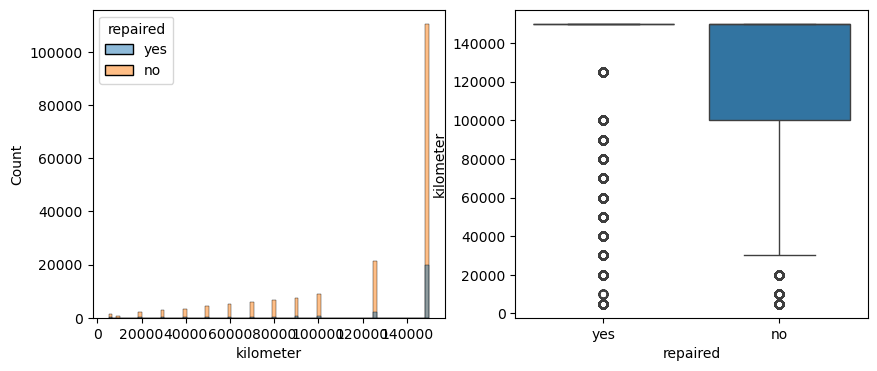

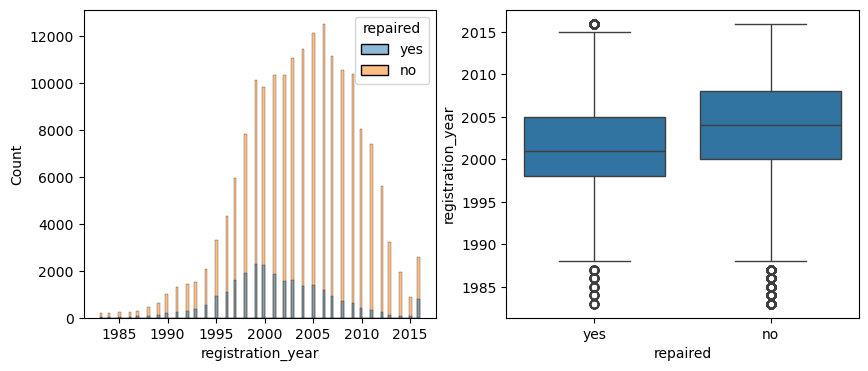

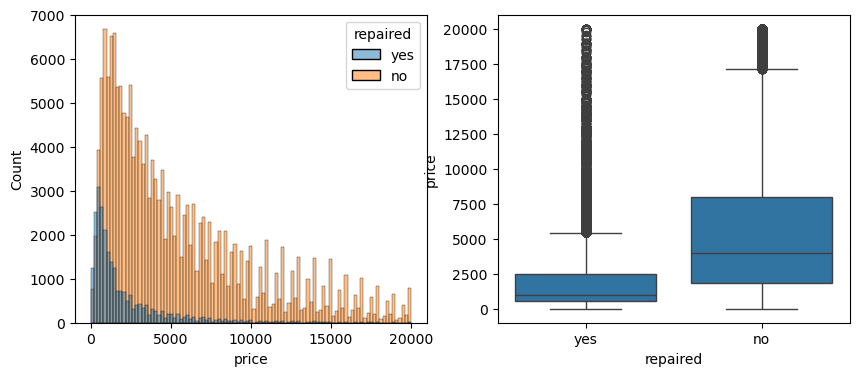

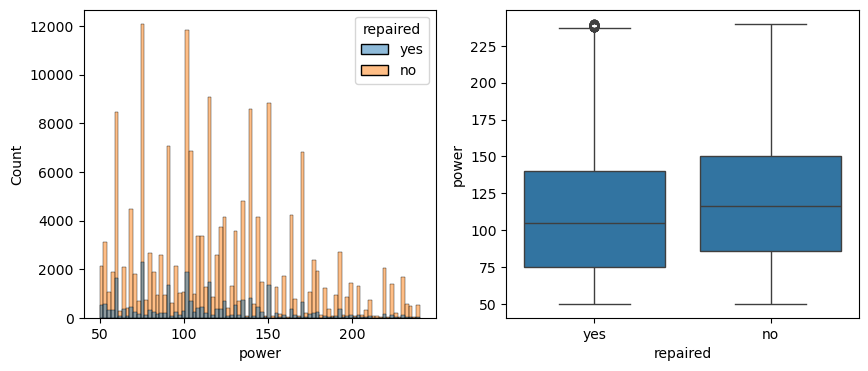

In [28]:
for num_column in num_col:
    plt.rcParams['figure.figsize'] = 10, 4
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=num_column, hue='repaired')
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, y=num_column, x='repaired')
    plt.show()

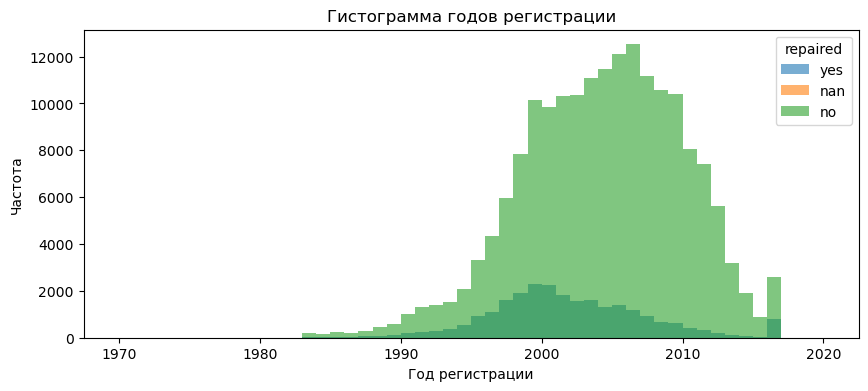

In [29]:
repaired_values = df['repaired'].unique()
for value in repaired_values:
    plt.hist(df[df['repaired'] == value]['registration_year'], bins=50, range=(1970, 2020), alpha=0.6, label=value)

plt.title('Гистограмма годов регистрации')
plt.xlabel('Год регистрации')
plt.ylabel('Частота')
plt.legend(title='repaired')

plt.show()

**Заметим, что есть**:
- Представленные машин имеют пробег более `80 000 км`, как правило - более `120 000 км`. При этом по данному показателю есть `небольшое число выбросов`;
- В данных с годом регистрации `большое количество выбросов`. Большинство машин были зарегистрированы с `1990 по 2018`. Машины, которые `ремонтировались`, как правило, `более старые`;
- Распределение цен на машины имеет `левосторонний номральный вид`. При этом в данных `большое количество выбросов`. Машины, которые `ремонитровались`, как правило `дешевле`.

Построим круговые диаграммы для категориальных признаков таблицы:

In [30]:
def pie_cat_col(df, cat_col, index=int):
    print(f'Круговая диаграмма для признака "{cat_col[index]}"')
    plt.rcParams['figure.figsize'] = 4, 4
    x=df.groupby([cat_col[index]])[cat_col[index]].count()
    plt.pie(x=x, labels=x.index, autopct='%1.1f%%', colors=plt.cm.Set2.colors)
    plt.show()

Круговая диаграмма для признака "vehicle_type"


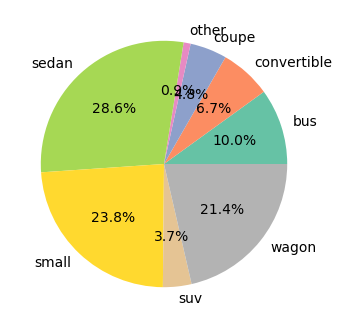

In [31]:
pie_cat_col(df, cat_col, 2)

Круговая диаграмма для признака "gearbox"


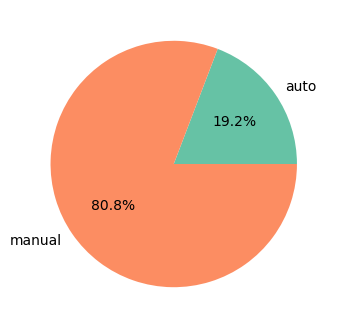

In [32]:
pie_cat_col(df, cat_col, 4)

Круговая диаграмма для признака "vehicle_type"


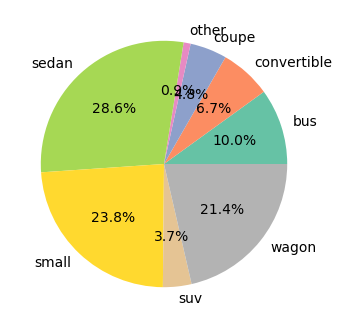

In [33]:
pie_cat_col(df, cat_col, 2)

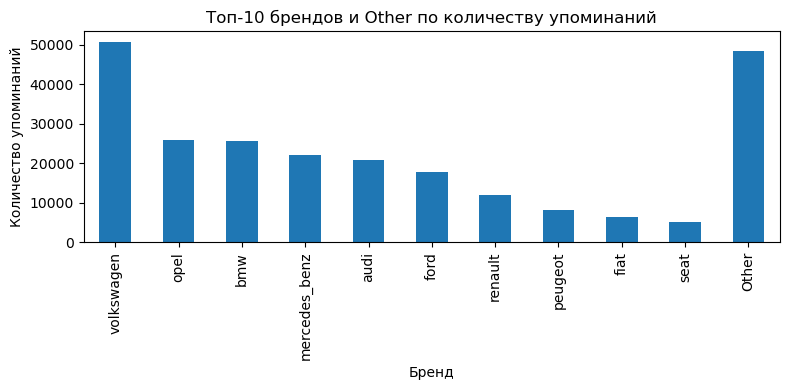

In [34]:
brand_counts = df['brand'].value_counts()

top_10_brands = brand_counts.head(10)

other_brands_count = brand_counts[10:].sum()

# Используем pd.concat вместо append
top_brands_combined = pd.concat([top_10_brands, pd.Series({'Other': other_brands_count})])

plt.figure(figsize=(8, 4))
top_brands_combined.plot(kind='bar')
plt.title('Топ-10 брендов и Other по количеству упоминаний')
plt.xlabel('Бренд')
plt.ylabel('Количество упоминаний')
plt.tight_layout()
plt.show()


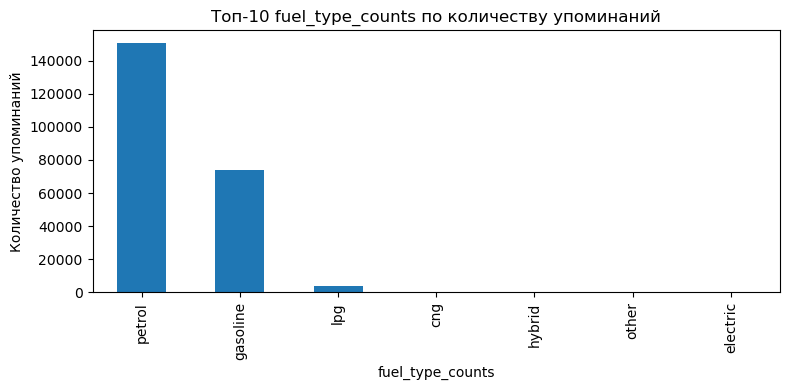

In [35]:
fuel_type_counts = df['fuel_type'].value_counts()

plt.figure(figsize=(8, 4))
fuel_type_counts.plot(kind='bar')
plt.title('Топ-10 fuel_type_counts по количеству упоминаний')
plt.xlabel('fuel_type_counts')
plt.ylabel('Количество упоминаний')
plt.tight_layout()
plt.show()

**Заметим, что есть**:
- `~29%` машин - `sedan`, `~25.3%` машин - `small`, `~20.7%` машин - `wagon`, `~9.1%` машин - `bus`;
- `80%` машин имеют `механическую` коробку передач, `20%` машин имеют `автоматическую` коробку передач;
- `~90%` машин  не ремонитровались, `~10%` машин - ремонитровались;
- наиболее `популярные бренды` мащин - `volkswagen`, `opel`, `bmw`, `mercedes_benz` и `audi`. Около `50 тыс.` машин - `менее известных` брендов;
- наиболее `популярные типы топлива` - `petrol` (`68%`) и `gasoline` (`31%`).

Посмотрим на взаимосвязь (корреляцию) числовых и категориальных признаков с помощью статистики `Phik (Φk)`:

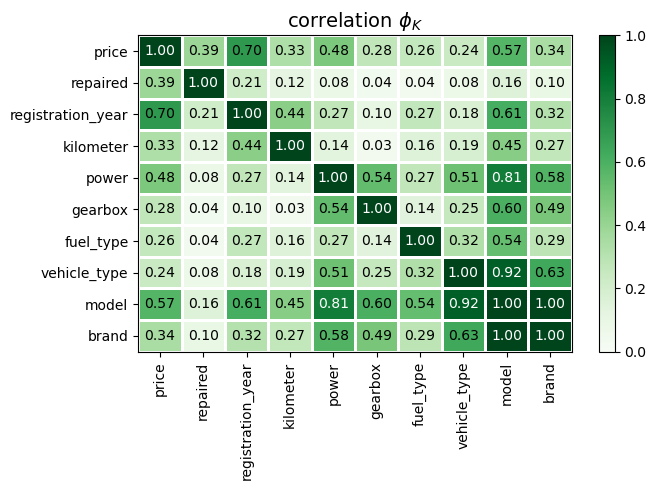

In [36]:
phik_overview = df.phik_matrix(interval_cols = ['power', 'kilometer', 'registration_year', 'price'])
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1,
                        figsize=(7, 5))
plt.tight_layout()

**Заметим, что есть**:
- `умеренная` положительная связь между `price` и `registration_year`;
- `умеренная` положительная связь между `model` и `gearbox`;
- `умеренная` положительная связь между `vehicle_type` и `brand`;
- `умеренная` положительная связь между `brand` и `gearbox`;
-----
- `сильная` положительная связь между `vehicle_type` и `model`;
- `сильная` положительная связь между `model` и `brand`.

<div class="alert"; style="border-left: 7px solid pink">

***Мини-вывод***:   
- **В результате исследовательсого анализа числовых признаков**:
    - Представленные машин имеют пробег более `80 000 км`, как правило - более `120 000 км`. При этом по данному показателю есть `небольшое число выбросов`;
    - В данных с годом регистрации `большое количество выбросов`. Большинство машин были зарегистрированы с `1990 по 2018`. Машины, которые `ремонтировались`, как правило, `более старые`;
    - Распределение цен на машины имеет `левосторонний номральный вид`. При этом в данных `большое количество выбросов`. Машины, которые `ремонитровались`, как правило `дешевле`

- **В результате исследовательсого анализа категориальных признаков**:
    - `~29%` машин - `sedan`, `~25.3%` машин - `small`, `~20.7%` машин - `wagon`, `~9.1%` машин - `bus`;
    - `80%` машин имеют `механическую` коробку передач, `20%` машин имеют `автоматическую` коробку передач;
    - `~90%` машин  не ремонитровались, `~10%` машин - ремонитровались;
    - наиболее `популярные бренды` мащин - `volkswagen`, `opel`, `bmw`, `mercedes_benz` и `audi`. Около `50 тыс.` машин - `менее известных` брендов;
    - наиболее `популярные типы топлива` - `petrol` (`68%`) и `gasoline` (`31%`).

- **В результате корреляционного анализа признаков**:
    - `умеренная` положительная связь между `price` и `registration_year`;
    - `умеренная` положительная связь между `price` и `model`;
    - `умеренная` положительная связь между `registration_year` и `model`;
    - `умеренная` положительная связь между `model` и `gearbox`;
    - `умеренная` положительная связь между `vehicle_type` и `brand`;
    - `умеренная` положительная связь между `brand` и `gearbox`;
    - `сильная` положительная связь между `vehicle_type` и `model`;
    - `сильная` положительная связь между `model` и `brand`.
</div>

## Подготовка данных к обучению <a id='4'> </a>

In [37]:
ohe_columns = ['brand', 'model', 'fuel_type', 'gearbox', 'repaired', 'vehicle_type']
num_columns = ['kilometer', 'registration_year', 'power']

In [38]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
)

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[['small', 'convertible', 'sedan', 'suv', 'wagon', 'coupe', 'bus', 'other']], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [39]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Для начала закодируем и масштабируем данные. Выполним это в пайплайне:

In [40]:
X = df.drop(['price'], axis=1)
y = df['price']

In [41]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, random_state=RANDOM_STATE)

## Обучение моделей <a id='5'> </a>

### DecisionTreeRegressor

In [42]:
pipe_final_DTR = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

param_distributions = {
    'models__min_samples_split': range(2, 6),
    'models__min_samples_leaf': range(1, 6),
    'models__max_depth': range(2, 6)
}

rs_dtr = RandomizedSearchCV(
    pipe_final_DTR,
    param_distributions = param_distributions,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    random_state=RANDOM_STATE
)

rs_dtr.fit(X_train, y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['brand',
                                                                                'model',
                                                                                'fuel_type',
                                                                                'gearbox',
                                                                                'repaired',
                                                                                'vehicle_type']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['kilometer',
                                                                                'registration_year',
                                                                                'power'])])),
                                             ('models',
                                              DecisionTreeRegressor(random_state=42))]),
                   n_jobs=1,
                   param_distributions={'models__max_depth': range(2, 6),
                                        'models__min_samples_leaf': range(1, 6),
                                        'models__min_samples_split': range(2, 6)},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [43]:
print('Время обучения', rs_dtr.refit_time_)
print('Гиперпараметры', rs_dtr.best_params_)
print('RMSE', round(abs(rs_dtr.best_score_)))

Время обучения 0.4257528781890869
Гиперпараметры {'models__min_samples_split': 4, 'models__min_samples_leaf': 3, 'models__max_depth': 5}
RMSE 2324


### LinearRegression

In [44]:
pipe_final_LR = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

param_distributions = {
    'models__fit_intercept': [True, False],
    'models__copy_X': [True, False]
}

rs_lr = RandomizedSearchCV(
    pipe_final_LR,
    param_distributions = param_distributions,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    random_state=RANDOM_STATE
)

rs_lr.fit(X_train, y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['brand',
                                                                                'model',
                                                                                'fuel_type',
                                                                                'gearbox',
                                                                                'repaired',
                                                                                'vehicle_type']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['kilometer',
                                                                                'registration_year',
                                                                                'power'])])),
                                             ('models', LinearRegression())]),
                   n_jobs=1,
                   param_distributions={'models__copy_X': [True, False],
                                        'models__fit_intercept': [True, False]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [45]:
print('Время обучения', rs_lr.refit_time_)
print('Гиперпараметры', rs_lr.best_params_)
print('RMSE', round(abs(rs_lr.best_score_)))

Время обучения 1.2306020259857178
Гиперпараметры {'models__fit_intercept': True, 'models__copy_X': True}
RMSE 2423


### LightGBM

In [46]:
model_lgb = lgb.LGBMRegressor(random_state=RANDOM_STATE, num_threads= 5)

for c in cat_col:
    X_train[c] = X_train[c].astype('category')

params = {
            'objective': ['regression'],
            'metric': ['mean_squared_error'],
            'boosting_type' : ['gbdt']
        }

rs_lgb = RandomizedSearchCV(
    model_lgb,
    params,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    random_state=RANDOM_STATE
)

In [47]:
rs_lgb.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 546
[LightGBM] [Info] Number of data points in the train set: 145862, number of used features: 9
[LightGBM] [Info] Start training from score 4793.713942


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 145862, number of used features: 9
[LightGBM] [Info] Start training from score 4794.211981
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 145862, number of used features: 9
[LightGBM] [Info] Start training from score 4776.927569
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(num_threads=5, random_state=42),
                   n_jobs=1,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'metric': ['mean_squared_error'],
                                        'objective': ['regression']},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [48]:
print('Время обучения', rs_lgb.refit_time_)
print('RMSE', round(abs(rs_lgb.best_score_)))

Время обучения 0.49607205390930176
RMSE 1521


Выберем лучшую модель, *основыясь на три признака*: RMSE по кросс-валидации, время обучения и скорость работы:

In [49]:
# сперва посчитаем скорость предсказания
start_time = time.time()
y_pred_lr = rs_lr.predict(X_test)
end_time = time.time()
prediction_time_lr = end_time - start_time

start_time = time.time()
y_pred_dtr = rs_dtr.predict(X_test)
end_time = time.time()
prediction_time_dtr = end_time - start_time

for c in cat_col:
    X_test[c] = X_test[c].astype('category')

start_time = time.time()
y_pred_lbg = rs_lgb.predict(X_test)
end_time = time.time()
prediction_time_lbg = end_time - start_time

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Далее произведем сравнение. Для удобства создадим таблицу:

In [50]:
models_info = {
    'Модель': ['Linear Regression', 'Decision Tree', 'LightGBM'],
    'Время обучения': [rs_lr.refit_time_, rs_dtr.refit_time_, rs_lgb.refit_time_],
    'Время предсказания': [prediction_time_lr, prediction_time_dtr, prediction_time_lbg],
    'RMSE': [round(abs(rs_lr.best_score_)), round(abs(rs_dtr.best_score_)), round(abs(rs_lgb.best_score_))]
}

models_comparison = pd.DataFrame(models_info)
display(models_comparison)

,Модель,Время обучения,Время предсказания,RMSE
0,Linear Regression,1.230602,0.070145,2423
1,Decision Tree,0.425753,0.071115,2324
2,LightGBM,0.496072,0.074483,1521


Как видим, оптимальнее всего - `LightGBM`. Даже несмотря на то, что она незначительно усткпает Decision Tree в скорости обучения.

Применим данную модель к тестовым данным и посчитаем `итоговую метрику`:

In [51]:
#качество предсказания
    
y_preds = rs_lgb.predict(X_test)
rmse = mean_squared_error(y_test, y_preds, squared=False)
print("Итогова метрика RMSE для модели LightGBM на тестовых данных: {:.2f}".format(rmse))

Итогова метрика RMSE для модели LightGBM на тестовых данных: 1515.44


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<div class="alert"; style="border-left: 7px solid pink">

**Мини-вывод**:   
- Опираясь на критерии заказчика - качество предсказания, время обучения модели и время предсказания модели - лучшей моделью является `LightGBM`
- `RMSE` = 1515
- `Время обучения`: < 1 сек.
- `Гиперпараметры`: {'objective': 'regression', 'metric': 'mean_squared_error', 'boosting_type': 'gbdt'}
</div>

##  Вывод <a id='6'> </a>

____
В рамках проекта анализировались данные сервиса по продаже автомобилей с пробегом «Не бит, не крашен» **с целью** построения модели, которая умеет определять рыночную стоимость автомобиля на основании данных о технических характеристиках, комплектации и ценах других автомобилей.
____
**В результате первичного изучения и предобработки данных было определено**:
- в таблице `354369` строк и `16` столбков (признаков)
- в стобцах `vehicle_type`, `gearbox`, `model`, `fuel_type`, `repaired` есть пропуски
- в таблице `10194` явных дубликатов
- есть записи с `нулевой ценой`
- есть с `нереальной годом` регистрации автомобиля (1000 г. и 9999 г.)
- есть записи с `нулевой мощностью` автомобиля
- есть записи с `нулевым месяцем` регистрации автомобиля
- во всех объявлениях` 0 фотографий` автомобиля (судя по данным)
- заполнение пропусков
- удаление аномалий
- Удаление дубликатов
- Удаление неинформативных признаков

____
**В результате предобработки данных было произведено**:
- заполнение пропусков
- удаление аномалий
- Удаление дубликатов
- Удаление неинформативных признаков
____
**В результате исследовательского и корреляционного анализа данных было определено**:
- Представленные машин имеют пробег более `80 000 км`, как правило - более `120 000 км`. При этом по данному показателю есть `небольшое число выбросов`;
- В данных с годом регистрации `большое количество выбросов`. Большинство машин были зарегистрированы с `1990 по 2018`. Машины, которые `ремонтировались`, как правило, `более старые`;
- Распределение цен на машины имеет `левосторонний номральный вид`. При этом в данных `большое количество выбросов`. Машины, которые `ремонитровались`, как правило `дешевле`
- `~29%` машин - `sedan`, `~25.3%` машин - `small`, `~20.7%` машин - `wagon`, `~9.1%` машин - `bus`;
- `80%` машин имеют `механическую` коробку передач, `20%` машин имеют `автоматическую` коробку передач;
- `~90%` машин  не ремонитровались, `~10%` машин - ремонитровались;
- наиболее `популярные бренды` мащин - `volkswagen`, `opel`, `bmw`, `mercedes_benz` и `audi`. Около `50 тыс.` машин - `менее известных` брендов;
- наиболее `популярные типы топлива` - `petrol` (`68%`) и `gasoline` (`31%`).
- `умеренная` положительная связь между `price` и `registration_year`;
- `умеренная` положительная связь между `price` и `model`;
- `умеренная` положительная связь между `registration_year` и `model`;
- `умеренная` положительная связь между `model` и `gearbox`;
- `умеренная` положительная связь между `vehicle_type` и `brand`;
- `умеренная` положительная связь между `brand` и `gearbox`;
- `сильная` положительная связь между `vehicle_type` и `model`;
- `сильная` положительная связь между `model` и `brand`;
____
В рамках разработки модели наилучшим образом себя показала модель `LightGBM`: `RMSE` = `1521`. Скорость обучения модели - `1.12 секунды`. Скорость предсказания - `0.29 секунды`.